# **Modeling and Evaluation**

## Objectives

* Answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

---

# Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib.image import imread

---

# Set working directory

Change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/mildew_detection')
print("Changed working directory to:", os.getcwd())

Changed working directory to: /workspaces/mildew_detection


Get the current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew_detection'

* #### Set input directories

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
validation_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

* #### Set output directories

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

* #### Check if previous version is available

In [7]:
if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available, Create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available, Create a new version.


* #### Set label

In [8]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['powdery_mildew', 'healthy']


* #### Load image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




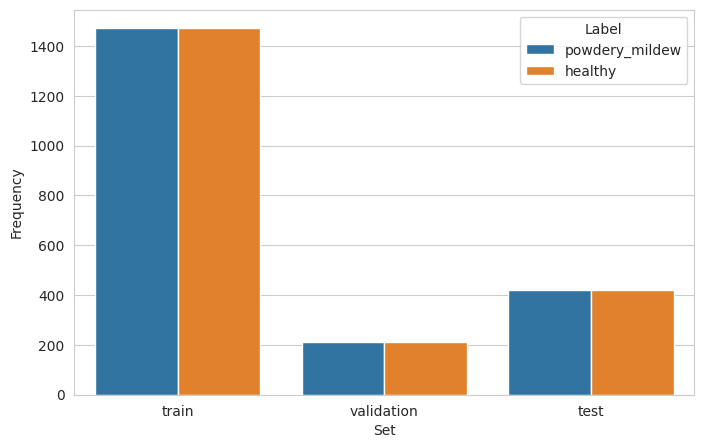

In [14]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

* #### Check distribution of sets

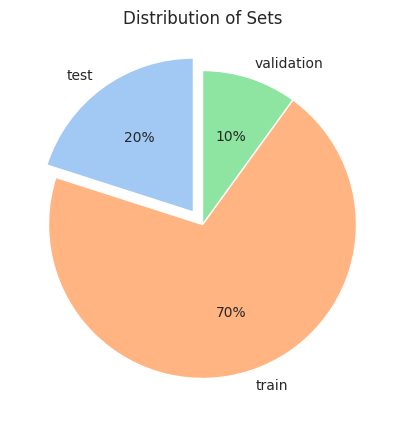

In [33]:
df_set_distribution = df_freq.groupby('Set')['Frequency'].sum().reset_index()

# Create a pie chart for the distribution of sets
plt.figure(figsize=(8, 5))
plt.pie(df_set_distribution['Frequency'], labels=df_set_distribution['Set'], autopct='%1.0f%%', startangle=90,
        colors=sns.color_palette('pastel'), explode=(0.1, 0, 0))  # Adjust explode for emphasis
plt.title('Distribution of Sets')
plt.savefig(f'{file_path}/sets_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

* #### Image Data Generator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* #### Initialize ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* #### Augment training image dataset

In [23]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* #### Plot augment training image

(20, 256, 256, 3)


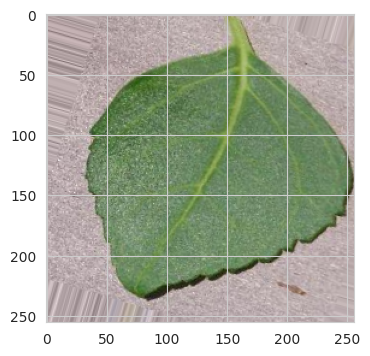

(20, 256, 256, 3)


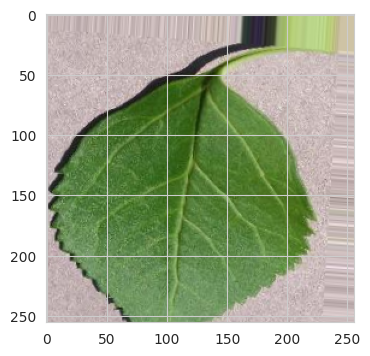

(20, 256, 256, 3)


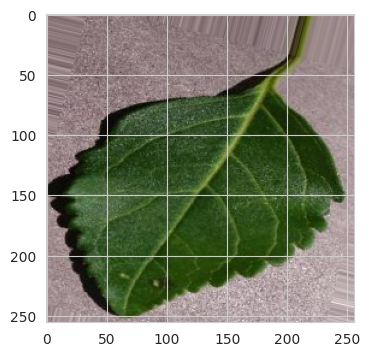

In [42]:
for _ in range(3):
    plt.figure(figsize=(4, 4))
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* #### Augment validation image dataset

In [24]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* #### Plot augment validation images

(20, 256, 256, 3)


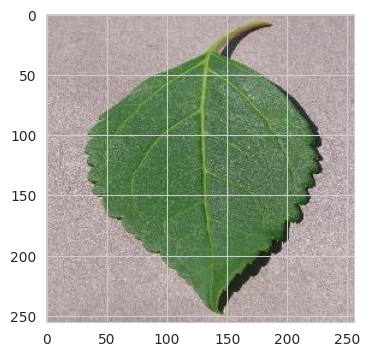

(20, 256, 256, 3)


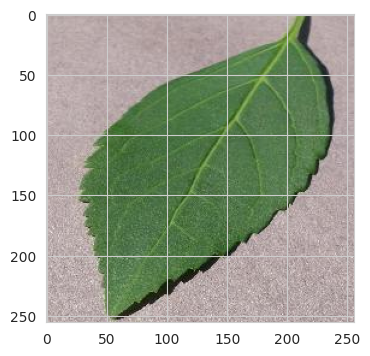

(20, 256, 256, 3)


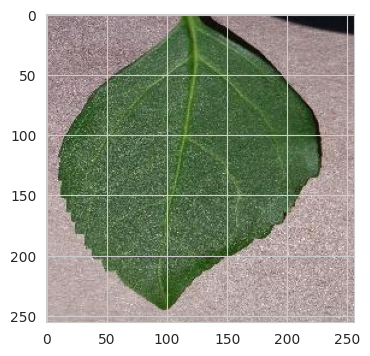

In [43]:
for _ in range(3):
    plt.figure(figsize=(4, 4))
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* #### Augment test image dataset

In [25]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* #### Plot augmented test image

(20, 256, 256, 3)


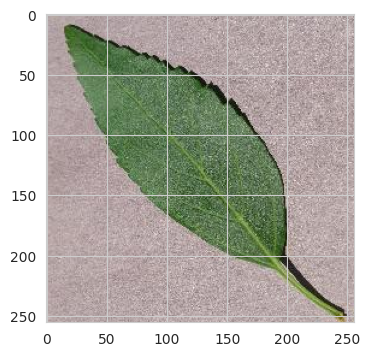

(20, 256, 256, 3)


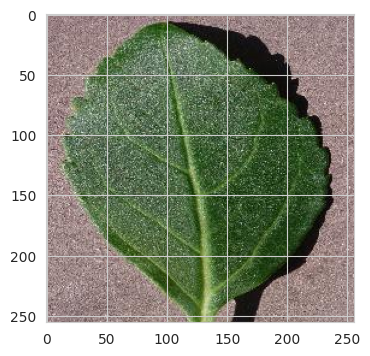

(20, 256, 256, 3)


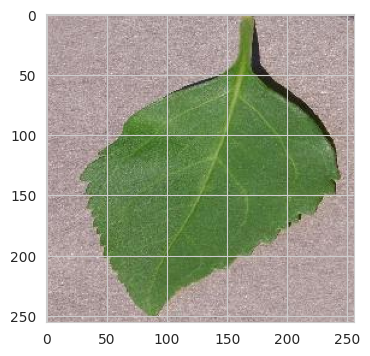

In [44]:
for _ in range(3):
    plt.figure(figsize=(4, 4))
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

---

# Model Creation

* #### Import model packages

In [45]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

* #### Model

In [46]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* #### Test Model

In [64]:
def test_model(train_set, validation_set, test_set):
    model = create_tf_model()

    print("Testing Convolutional Neural Network...")
    model.fit(train_set, epochs=1, steps_per_epoch=len(train_set) // batch_size,
              validation_data=validation_set, verbose=0)

    y_pred = (model.predict(test_set) > 0.5).astype("int32")

    accuracy = accuracy_score(test_set.classes, y_pred)
    precision = precision_score(test_set.classes, y_pred)
    recall = recall_score(test_set.classes, y_pred)
    f1 = f1_score(test_set.classes, y_pred)

    results = {
        'Convolutional Neural Network': {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
    }

    print("Results for Convolutional Neural Network:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")

    return results

In [66]:
test_result = test_model(train_set, validation_set, test_set)
print("Results outside the function:")
print(test_result)


Testing Convolutional Neural Network...
Results for Convolutional Neural Network:
Accuracy: 0.5237
Precision: 1.0000
Recall: 0.0474
F1 Score: 0.0905


Results outside the function:
{'Convolutional Neural Network': {'Accuracy': 0.523696682464455, 'Precision': 1.0, 'Recall': 0.04739336492890995, 'F1 Score': 0.09049773755656107}}


* #### Model Summary

In [67]:
create_tf_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 57600)            

---

* #### Early Stopping

In [68]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
